# Cybersecurity Loss Exceedance Curve (LEC) workbook

Estimate the chance of period loss exceeding a given amount using Monte Carlo. Translate qualitative scenarios into a quantitative loss profile, produce an LEC, and compare to risk appetite and insurance limits.


## Read this first
1. Use one currency and one period. Default period is one year.
2. Each row is an event with period probability and a loss range when it occurs.
3. The model samples event occurrence, then samples loss via a lognormal distribution shaped by your lower and upper bounds.
4. Total loss per period equals the sum of sampled losses for events that occurred.
5. The LEC plots `P(Loss ≥ x)` vs `x`.


## Parameter justification and citations
Use these references to justify initial ranges. Replace with your sources as you calibrate.

- **Breach cost baseline.** IBM Cost of a Data Breach 2025 global average ≈ **$4.44M**. Anchor for breach rows and tails. [IBM report hub](https://www.ibm.com/reports/data-breach) and third‑party brief [Baker Donelson PDF](https://www.bakerdonelson.com/webfiles/Publications/20250822_Cost-of-a-Data-Breach-Report-2025.pdf).
- **BEC frequency and losses.** FBI IC3 2024 shows large aggregate losses with BEC a major driver. [FBI release](https://www.fbi.gov/news/press-releases/fbi-releases-annual-internet-crime-report) and [IC3 2024 report PDF](https://www.ic3.gov/AnnualReport/Reports/2024_IC3Report.pdf). NetDiligence 2024 Cyber Claims Study reports average BEC claim ≈ **$183K** (2023). [NetDiligence 2024](https://netdiligence.com/press-releases/netdiligence-releases-2024-cyber-claims-study/).
- **Ransomware context.** Verizon DBIR 2025 highlights ransomware within system intrusion breaches and continuing severity. [DBIR portal](https://www.verizon.com/business/resources/reports/dbir/) and [DBIR 2025 PDF](https://www.verizon.com/business/resources/Tea/reports/2025-dbir-data-breach-investigations-report.pdf).
- **Privacy fines.** Use GDPR Enforcement Tracker to bound regulatory tails and sanity‑check eight‑figure outliers. [Enforcement Tracker](https://www.enforcementtracker.com/?insights=) and example coverage [Reuters example](https://www.reuters.com/technology/eu-privacy-regulator-fines-meta-91-million-euros-over-password-storage-2024-09-27/).

**Mapping to ranges**
- Start breach central tendency near IBM mean. Set upper bound 2–3× higher for fat tails.
- For BEC set lower bound near recovery/response. Set upper bound near NetDiligence averages plus legal and downtime. Probability from historical BEC cases per year.
- For ransomware stretch upper bound to reflect double extortion and outage. Probability from incident counts and industry baselines.
- For privacy fines set low probability and translate EUR tails to USD.


## 1) Setup

In [27]:
# install dependencies: pip install numpy pandas matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO

pd.set_option("display.float_format", "{:,.2f}".format)

# Probability is stored 0–1 internally. Displayed as percentage strings in tables.
def fmt_percent_0to1(v): 
    try:
        return f"{100*float(v):.2f}%"
    except Exception:
        return v

def style_probability_percent(df: pd.DataFrame):
    cols = [c for c in df.columns if c.lower() == "probability"]
    fmt = {c: fmt_percent_0to1 for c in cols}
    return df.style.format(fmt)


def event_happens(probability: float) -> bool:
    return np.random.rand() < probability

def lognormal_event_result(lower: float, upper: float) -> float:
    if lower <= 0 or upper <= 0 or lower >= upper:
        raise ValueError("Bounds must be positive and lower < upper")
    q95 = 1.6448536269514722
    q05 = -q95
    mu = (np.log(lower) * q95 + np.log(upper) * (-q05)) / (q95 - q05)
    sigma = (np.log(upper) - np.log(lower)) / (q95 - q05)
    return np.random.lognormal(mean=mu, sigma=sigma)

def simulate_scenario(events_df: pd.DataFrame) -> float:
    total = 0.0
    for _, row in events_df.iterrows():
        if event_happens(float(row['Probability'])):
            total += lognormal_event_result(float(row['Lower']), float(row['Upper']))
    return total

def monte_carlo_simulation(events_df: pd.DataFrame, rounds: int = 10000) -> np.ndarray:
    return np.array([simulate_scenario(events_df) for _ in range(rounds)])

def format_currency(x, pos=None):
    return '${:,.0f}'.format(x)

def plot_lec(bin_centers: np.ndarray, exceedance_pct: np.ndarray, x_min=None, x_max=None, title_suffix="", vlines=None):
    if x_min is None:
        x_min = float(np.nanmin(bin_centers))
    if x_max is None:
        x_max = float(np.nanmax(bin_centers))
    x_values = np.linspace(x_min, x_max, 10)
    y_values = [exceedance_pct[np.argmin(np.abs(bin_centers - x))] for x in x_values]
    plt.figure(figsize=(11, 7))
    plt.plot(bin_centers, exceedance_pct, label='Probability of loss ≥ x')
    plt.xlabel("Loss estimates")
    plt.ylabel("Chance of loss or greater (%)")
    plt.title(f"Loss Exceedance Curve {title_suffix}")
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.xlim(x_min, x_max)
    plt.ylim(0, max(100, np.nanmax(exceedance_pct)))
    ax = plt.gca()
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: format_currency(val)))
    ax.set_xticks(x_values)
    ax.set_xticklabels([format_currency(val) for val in x_values], rotation=45)
    for x, y in zip(x_values, y_values):
        plt.annotate(f"{y:.2f}%", (x, y), textcoords="offset points", xytext=(5, 8))
    if vlines:
        for x, label in vlines:
            plt.axvline(x, linestyle=':', linewidth=1)
            plt.text(x, ax.get_ylim()[1]*0.95, label, rotation=90, va='top', ha='right')
    plt.tight_layout()
    plt.legend()
    plt.show()

def percentile_table(samples: np.ndarray, percentiles=(50, 75, 90, 95, 99)) -> pd.DataFrame:
    vals = np.percentile(samples, percentiles)
    return pd.DataFrame({"Percentile": percentiles, "Loss": vals})

def exceedance_at_thresholds(samples: np.ndarray, thresholds) -> pd.DataFrame:
    samples = np.asarray(samples)
    n = len(samples)
    rows = []
    for t in thresholds:
        pct = 100.0 * np.sum(samples >= t) / n
        rows.append({"Threshold": t, "Exceedance": f"{pct:.2f}%"})
    return pd.DataFrame(rows)

def insurance_effect(samples: np.ndarray, deductible: float, limit: float) -> pd.DataFrame:
    samples = np.asarray(samples)
    retained = np.minimum(samples, deductible) + np.maximum(samples - deductible - limit, 0)
    insured = samples - retained
    df = pd.DataFrame({
        'GrossLoss': samples,
        'CompanyRetained': retained,
        'InsurerPays': insured
    })
    return df


## 2) Scenario library (edit as needed)

In [28]:
scenario_library = pd.DataFrame([
    {"Event":"Ransomware exfiltration","Probability":0.05,"Lower":360_800,"Upper":16_800_000},
    {"Event":"Business email compromise","Probability":0.15,"Lower":25_000,"Upper":600_000},
    {"Event":"Third party outage","Probability":0.10,"Lower":50_000,"Upper":1_500_000},
    {"Event":"DDoS revenue impact","Probability":0.08,"Lower":40_000,"Upper":900_000},
    {"Event":"Cloud misconfiguration","Probability":0.12,"Lower":80_000,"Upper":2_500_000},
    {"Event":"Insider data theft","Probability":0.06,"Lower":120_000,"Upper":5_000_000},
    {"Event":"Lost laptop with data","Probability":0.20,"Lower":10_000,"Upper":250_000},
    {"Event":"Credential stuffing cleanup","Probability":0.18,"Lower":35_000,"Upper":700_000},
    {"Event":"Privacy investigation and fine","Probability":0.03,"Lower":200_000,"Upper":8_000_000},
    {"Event":"Legal defense and e-discovery","Probability":0.07,"Lower":60_000,"Upper":2_000_000},
    {"Event":"Production halt / OT","Probability":0.02,"Lower":250_000,"Upper":12_000_000},
])
style_probability_percent(scenario_library)


,Event,Probability,Lower,Upper
0,Ransomware exfiltration,5.00%,360800,16800000
1,Business email compromise,15.00%,25000,600000
2,Third party outage,10.00%,50000,1500000
3,DDoS revenue impact,8.00%,40000,900000
4,Cloud misconfiguration,12.00%,80000,2500000
5,Insider data theft,6.00%,120000,5000000
6,Lost laptop with data,20.00%,10000,250000
7,Credential stuffing cleanup,18.00%,35000,700000
8,Privacy investigation and fine,3.00%,200000,8000000
9,Legal defense and e-discovery,7.00%,60000,2000000


## 3) Input methods

### Option A: Paste CSV
Required headers: `Probability,Lower,Upper`. Optional `Event`.

In [29]:
USE_PASTED_CSV = True
PASTED_CSV = """
Event,Probability,Lower,Upper
Ransomware exfiltration,0.05,360800,16800000
Business email compromise,0.15,25000,600000
Third party outage,0.10,50000,1500000
"""
events_df_pasted = None
if USE_PASTED_CSV:
    events_df_pasted = pd.read_csv(StringIO(PASTED_CSV.strip()))
    display(style_probability_percent(events_df_pasted))


,Event,Probability,Lower,Upper
0,Ransomware exfiltration,5.00%,360800,16800000
1,Business email compromise,15.00%,25000,600000
2,Third party outage,10.00%,50000,1500000


### Option B: Load CSV from file path

In [4]:
USE_FILE_CSV = False
CSV_PATH = "events.csv"
events_df_file = None
if USE_FILE_CSV:
    events_df_file = pd.read_csv(CSV_PATH)
    display(style_probability_percent(events_df_file))


### Option C: Inline Python list (default uses the library above)

In [ ]:
USE_INLINE_DATA = False
events_df_inline = scenario_library.copy()
style_probability_percent(events_df_inline)


## 4) Activate dataset and validate

In [30]:
if USE_PASTED_CSV and events_df_pasted is not None:
    events_df = events_df_pasted.copy()
elif USE_FILE_CSV and events_df_file is not None:
    events_df = events_df_file.copy()
elif USE_INLINE_DATA:
    events_df = events_df_inline.copy()
else:
    events_df = scenario_library.copy()

display(style_probability_percent(events_df))

required = {'Probability','Lower','Upper'}
if not required.issubset(events_df.columns):
    raise ValueError("Missing required columns. Expected Probability, Lower, Upper")
if (events_df['Probability'] < 0).any() or (events_df['Probability'] > 1).any():
    raise ValueError("Probabilities must be between 0 and 1")
if (events_df['Lower'] <= 0).any() or (events_df['Upper'] <= 0).any():
    raise ValueError("Lower and Upper must be positive")
if (events_df['Lower'] >= events_df['Upper']).any():
    raise ValueError("Each row requires Lower < Upper")


,Event,Probability,Lower,Upper
0,Ransomware exfiltration,5.00%,360800,16800000
1,Business email compromise,15.00%,25000,600000
2,Third party outage,10.00%,50000,1500000


## 5) Settings

In [31]:
ROUNDS = 60000
BINS = 240
X_MAX_VISUAL = 18_000_000
TITLE_SUFFIX = "- Cyber scenarios"
# np.random.seed(42)


## 6) Run simulation and plot

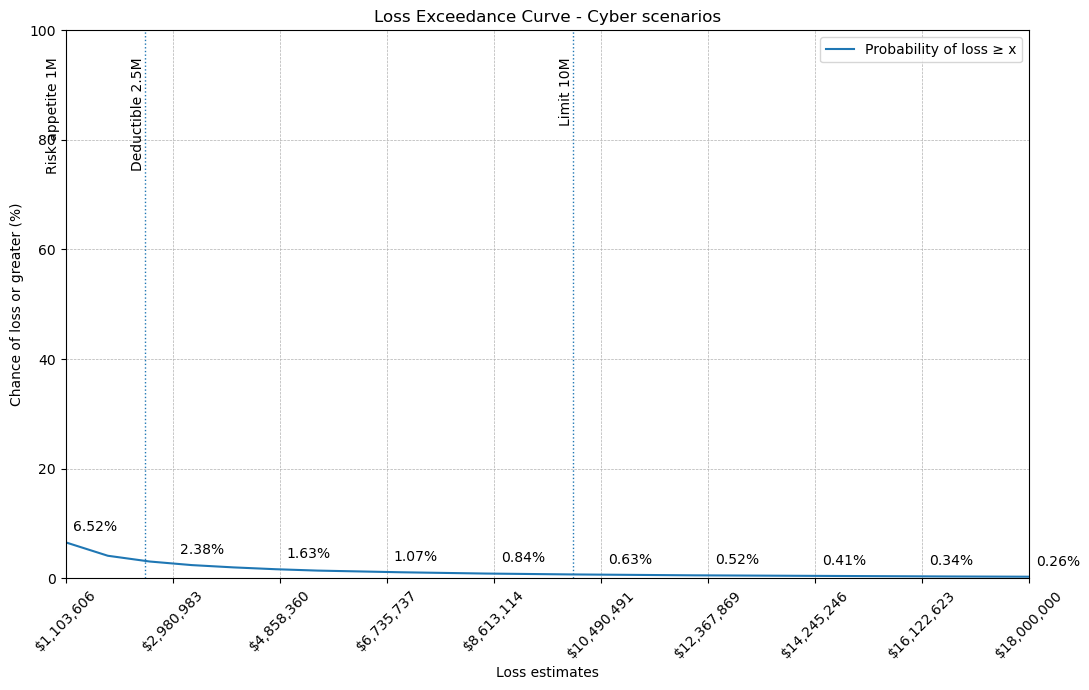

In [32]:
samples = monte_carlo_simulation(events_df[['Probability','Lower','Upper']], rounds=ROUNDS)
hist, edges = np.histogram(samples, bins=BINS)
tail = np.cumsum(hist[::-1])[::-1]
exceedance_pct = 100.0 * tail / len(samples)
exceedance_pct = exceedance_pct[1:]
bin_centers = 0.5 * (edges[:-1] + edges[1:])[1:]

VLINES = [
    (1_000_000, "Risk appetite 1M"),
    (2_500_000, "Deductible 2.5M"),
    (10_000_000, "Limit 10M"),
]
plot_lec(bin_centers, exceedance_pct, x_min=float(np.nanmin(bin_centers)), x_max=X_MAX_VISUAL, title_suffix=TITLE_SUFFIX, vlines=VLINES)


## 7) Summary tables

In [34]:
percentiles = percentile_table(samples, percentiles=(50, 75, 90, 95, 97.5, 99))
percentiles


,Percentile,Loss
0,50.00,0.00
1,75.00,"45,245.84"
2,90.00,"390,637.66"
3,95.00,"1,083,198.16"
4,97.50,"2,800,219.91"
5,99.00,"7,057,896.57"


In [35]:
thresholds = [250_000, 500_000, 1_000_000, 2_500_000, 5_000_000, 10_000_000, 15_000_000]
ex_table = exceedance_at_thresholds(samples, thresholds)
ex_table


,Threshold,Exceedance
0,250000,13.34%
1,500000,8.43%
2,1000000,5.26%
3,2500000,2.75%
4,5000000,1.42%
5,10000000,0.65%
6,15000000,0.35%


## 8) Insurance analysis

In [36]:
DEDUCTIBLE = 2_500_000
LIMIT = 10_000_000
insured_df = insurance_effect(samples, deductible=DEDUCTIBLE, limit=LIMIT)
insured_df.describe()[['GrossLoss','CompanyRetained','InsurerPays']]


,GrossLoss,CompanyRetained,InsurerPays
count,"60,000.00","60,000.00","60,000.00"
mean,"338,272.73","226,885.91","111,386.81"
std,"2,350,574.35","1,725,945.52","888,328.45"
min,0.00,0.00,0.00
25%,0.00,0.00,0.00
50%,0.00,0.00,0.00
75%,"45,245.84","45,245.84",0.00
max,"176,576,887.05","166,576,887.05","10,000,000.00"


## 9) Sensitivity examples

Monte Carlo sensitivity analysis is a probabilistic technique that combines the random sampling of Monte Carlo simulations with the goal of sensitivity analysis to understand how input variables affect a model's output. It runs numerous simulations, each with randomly sampled input values from their respective probability distributions, to create a probability distribution of possible outputs, revealing the influence and importance of each input parameter. 

Halved probability in Monte Carlo sensitivity analysis refers to a specific type of
probabilistic sensitivity analysis (PSA) where you test the impact of a 50% reduction in the probability of a specific variable or event occurring. This is a targeted sensitivity test used in conjunction with a larger Monte Carlo simulation to understand how sensitive the model's outcomes are to a significant change in a single probability variable.

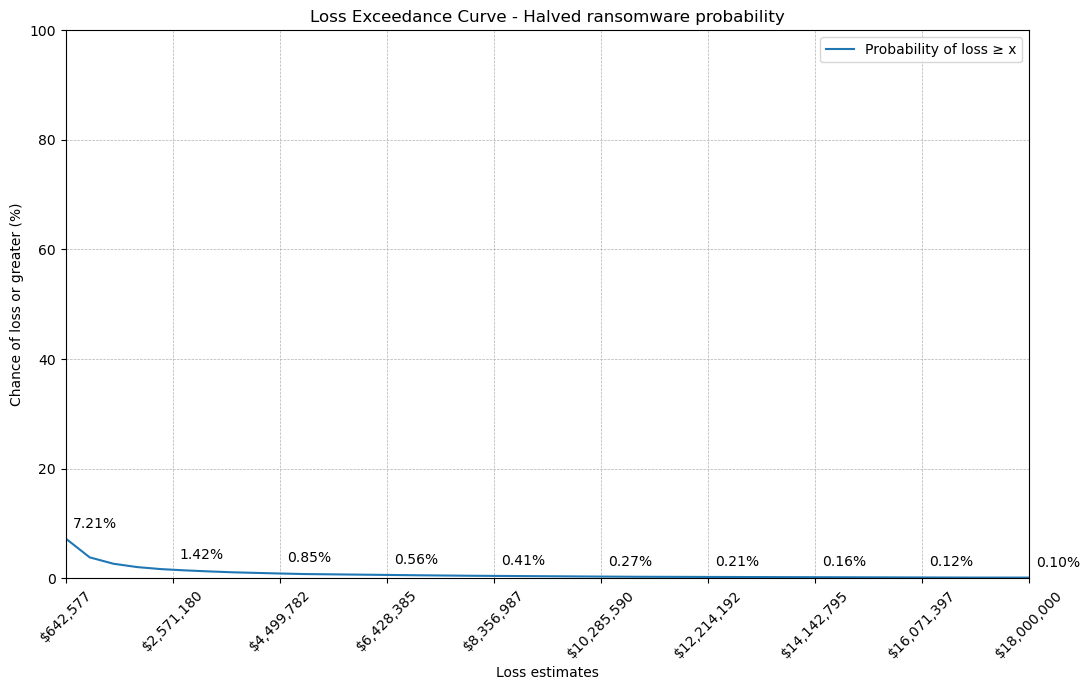

In [37]:
def tweak_and_plot(df, tweaks, title):
    base = df.copy()
    for rule in tweaks:
        mask = rule['mask'](base)
        for col, func in rule['updates'].items():
            base.loc[mask, col] = base.loc[mask, col].apply(func)
    s = monte_carlo_simulation(base[['Probability','Lower','Upper']], rounds=ROUNDS)
    h, e = np.histogram(s, bins=BINS)
    t = np.cumsum(h[::-1])[::-1]
    exc = 100.0 * t / len(s)
    exc = exc[1:]
    bc = 0.5 * (e[:-1] + e[1:])[1:]
    plot_lec(bc, exc, x_min=float(np.nanmin(bc)), x_max=X_MAX_VISUAL, title_suffix=title)
    return s

# Example 1: halve ransomware probability (assumes first row is ransomware)
t1 = tweak_and_plot(
    events_df,
    tweaks=[{
        'mask': lambda d: d.index == 0,
        'updates': {'Probability': lambda x: max(0, x*0.5)}
    }],
    title="- Halved ransomware probability"
)
